## Modeling Questions


* F1 score, when under 33%, is simply atrocious. All smokers in SVC.
* I SHOULD consider going back to drinking & drugs adding in.
* If I add new features, I need to re-run all models.

#### KNN
* Lazy
* Fits **fast**, predicts **slow**
* Fits d-dimensional data in `O(dn)` time
* Higher memory (saves entire data set)
* Various implementations (weighted, uniform)


In [400]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as st
# import pymc3 as pm
import seaborn as sns

# enables inline plots, without it plots don't show up in the notebook
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# %config InlineBackend.figure_format = 'png'
# mpl.rcParams['figure.dpi']= 300

pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 60)
pd.set_option('display.precision', 3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import sklearn
from sklearn.preprocessing import StandardScaler, Binarizer, LabelBinarizer, MultiLabelBinarizer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, cross_validate \
                                    , cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix,recall_score,precision_score, f1_score
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import roc_curve, auc

import itertools
from sklearn.metrics import confusion_matrix

# Helper Functions

In [121]:
target_names=['does not smoke','smokes']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def confusion_matrices(fit_model):
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, fit_model.predict(X_test))
    np.set_printoptions(precision=2)
    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=target_names,
                          title='Confusion matrix, without normalization')
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=target_names, normalize=True,
                          title='Confusion matrix, Normalized')

In [130]:
def plot_auc_curve(fit_model):
    y_score=fit_model.predict_proba(X_test)[:,1]
    fpr, tpr,_ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,6))
    # Plotting the Baseline
    plt.plot([0,1],[0,1])
    plt.plot(fpr,tpr)
    plt.grid(which='major')
    plt.title(f"{fit_model} AUC curve")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate');

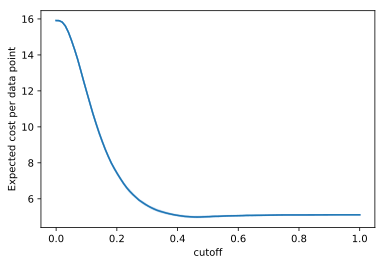

In [63]:
def makecost(obs,prob,falsepos_cost,falseneg_cost):
    def cost(cutoff):
        pred = np.array(prob > cutoff)
        fpos = pred * (1 - obs) 
        fneg = (1 - pred) * obs
        return np.sum(fpos * falsepos_cost + fneg * falseneg_cost)
    return np.vectorize(cost)

cut = np.linspace(0,1,100)
cost = np.zeros_like(cut)
from sklearn.model_selection import KFold, cross_val_predict
obs = np.ravel(y)

K = 20
for j in range(K):
    folds = KFold(n_splits=5,shuffle=True)
    prob = cross_val_predict(logreg,X,np.ravel(y),cv=folds,method='predict_proba',n_jobs=5)[:,1]
    getcost = makecost(obs,prob,falsepos_cost=20,falseneg_cost=25)
    currentcost = getcost(cut)/X.shape[0]
    cost += currentcost
    plt.plot(cut, currentcost,c='C0',alpha=0.05)
cost /= K
plt.plot(cut,cost,c='C0')
plt.xlabel('cutoff')
plt.ylabel('Expected cost per data point');

In [2]:
cupid = load_pd_pkl('data/cupid_cleaned')

In [250]:
target = ['binary_smokes']
continuous = ['age', 'height']
# bi_categorical = ['sex', 'wants_kids', 'signs_fun', 'signs_unimportant', 'signs_important',
#                      'religion_unserious', 'religion_laughing', 'religion_somewhat',
#                      'religion_serious', ]
# mult_categorical = ['body_type', 'drinks', 'drugs', 'income', 'orientation', 'status',
#                       'diet_intensity', 'diet_choice', 'primary_ethnicity',
#                       'has_kids','likes_cats', 'likes_dogs', 'dislikes_cats', 'dislikes_dogs',
#                       'has_cats', 'has_dogs','english_fluent','english_poor','spanish_fluent',
#                       'spanish_not_poorly','religion_name','new_education',]



# remove from bi: 'signs_fun', 'signs_unimportant', 'signs_important', 

bi_categorical = ['sex', 'wants_kids',
                     'religion_unserious', 'religion_laughing', 'religion_somewhat',
                     'religion_serious', ]

# remove from multi: 'drinks', 'drugs', 'new_education','likes_cats', 'likes_dogs', 'dislikes_cats', 
#          'dislikes_dogs', 'has_cats', 'has_dogs', 'primary_ethnicity', 'religion_name', 
#          'english_fluent','english_poor','spanish_fluent','spanish_not_poorly',
                      
mult_categorical = ['body_type', 'income', 'orientation', 'status',
                      'diet_intensity', 'diet_choice',
                      'has_kids',]


# Assign feature groupings
columns = bi_categorical + mult_categorical + target

# Create DF of everything
df = cupid[target + continuous + bi_categorical + mult_categorical]

### Change data type of age
df['age'] = df.age.astype(float)

df = df.dropna()

# Split DF of only standardized/scaled features
scaled_features = df.copy().loc[:, continuous]

# Tranform age and height (standardized features)
features = scaled_features[continuous]
features = StandardScaler().fit_transform(features.values)
scaled_features[continuous] = features

# Create dummy variables for original features, then combine back with scaled features
dummies = pd.get_dummies(df.loc[:, columns], columns=columns, drop_first=False)
df = scaled_features.join(dummies)

# Drop all "placeholder" columns
df.drop(df.filter(regex='placeholder'), axis=1, inplace=True)

# Drop "No" smoking column
df.drop(columns="binary_smokes_no", axis=1, inplace=True)

# SETUP MODELING DATA

X = df.drop('binary_smokes_yes', axis=1)
y = df['binary_smokes_yes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

/home/spencer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


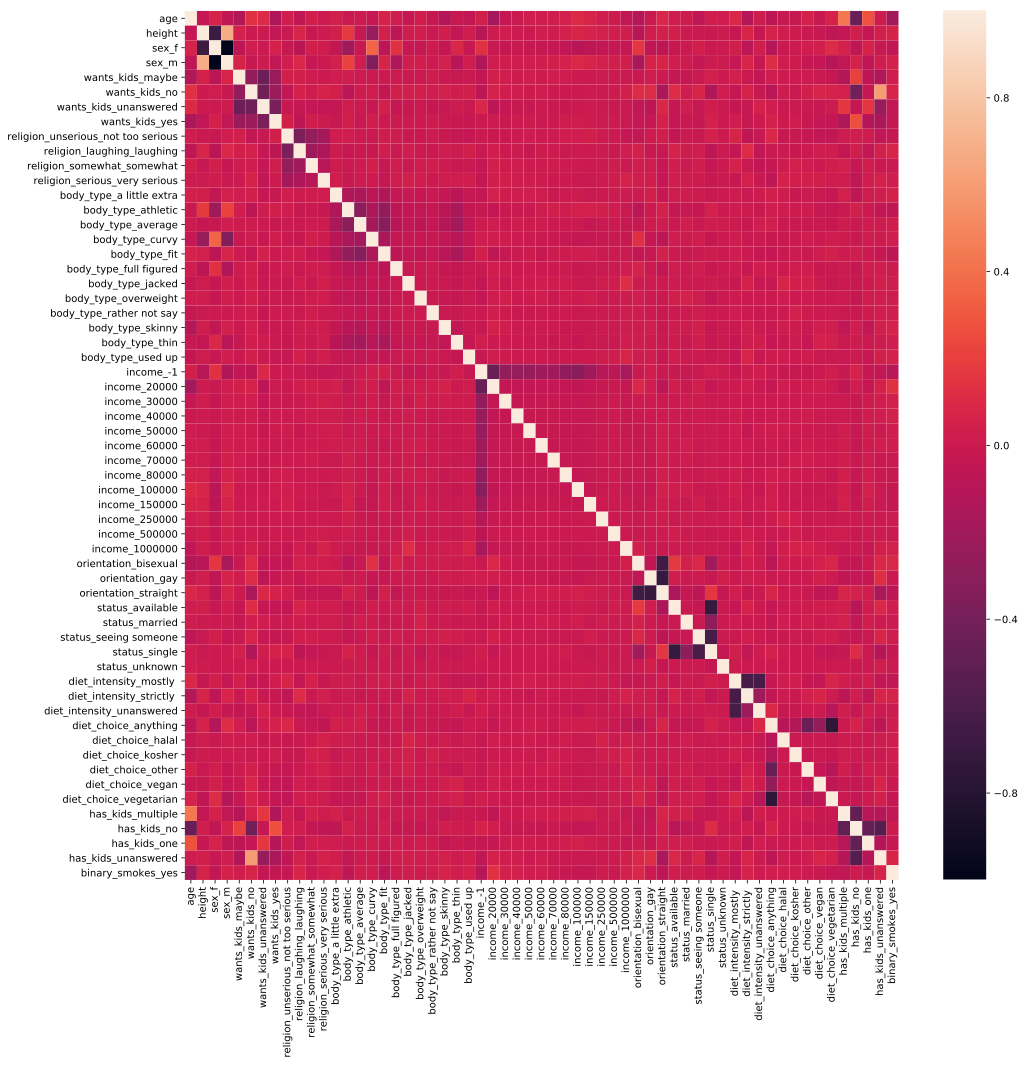

In [251]:
fig, ax = plt.subplots(figsize=(16,16))
sns.heatmap(df.corr(), xticklabels=True);

In [252]:
df.shape

(12824, 59)

In [33]:
# knn = KNeighborsClassifier(n_neighbors=1)
# scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
# print(scores)

# k_range = list(range(9, 15))
# k_scores = []
# for k in k_range:
#     knn = KNeighborsClassifier(n_neighbors=k)
#     scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
#     k_scores.append(scores.mean())
# print(k_scores)

# # plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
# plt.plot(k_range, k_scores)
# plt.xlabel('Value of K for KNN')
# plt.ylabel('Cross-Validated Accuracy');

# K-Nearest Neighbors (KNN)

## GridSearchCV

### Warning, this is quite computationally heavy! (30+ minutes)


### A few RandomizedSearchCV searches helped me narrow the range to between K = 1-8. Both uniform and distance were the best results for weight.

In [265]:
knn = KNeighborsClassifier()

# define the parameter values that should be searched
k_range = list(range(1, 7))
weight_options = ['uniform', 'distance']
scores = ['accuracy', 'precision', 'recall']

# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(n_neighbors=k_range, weights=weight_options)
# print(param_grid)

# instantiate the grid
grid = GridSearchCV(knn, param_grid, cv=10, scoring='f1')

# fit the grid with data
grid.fit(X_train, y_train);

# examine the best model
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.2588087226055862
{'n_neighbors': 1, 'weights': 'uniform'}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')


In [266]:
y_pred = grid.predict(X_test)

In [267]:
y_pred.

array([1, 1, 1, ..., 1, 0, 0], dtype=uint8)

classification report: 

                precision    recall  f1-score   support

does not smoke       0.82      0.84      0.83      3086
        smokes       0.29      0.27      0.28       762

     micro avg       0.72      0.72      0.72      3848
     macro avg       0.56      0.55      0.55      3848
  weighted avg       0.72      0.72      0.72      3848

accuracy score: 

0.7247920997920998
Confusion matrix, without normalization
[[2586  500]
 [ 559  203]]
Normalized confusion matrix
[[0.84 0.16]
 [0.73 0.27]]


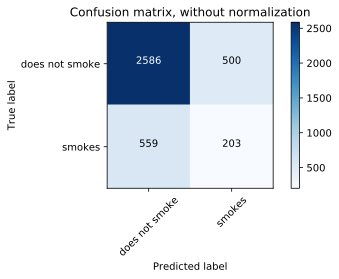

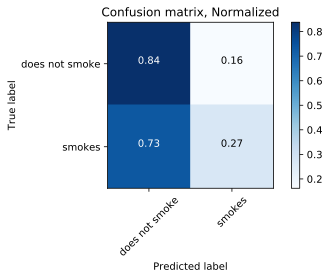

In [271]:
print("classification report: \n")
print(metrics.classification_report(y_test, y_pred, target_names=['does not smoke','smokes']))
print("accuracy score: \n")
print(metrics.accuracy_score(y_test, y_pred))
confusion_matrices(grid)

## `RandomizedSearchCV`

In [7]:
# k_range = list(range(10, 31))
# weight_options = ['uniform']      #, 'distance']

# # specify "parameter distributions" rather than a "parameter grid"
# param_dist = dict(n_neighbors=k_range, weights=weight_options)

# rand = RandomizedSearchCV(knn, param_dist, cv=5, scoring='accuracy', n_iter=10, random_state=42)
# rand.fit(X, y)
# rand.cv_results_['params']

[{'weights': 'uniform', 'n_neighbors': 10},
 {'weights': 'uniform', 'n_neighbors': 27},
 {'weights': 'uniform', 'n_neighbors': 25},
 {'weights': 'uniform', 'n_neighbors': 11},
 {'weights': 'uniform', 'n_neighbors': 18},
 {'weights': 'uniform', 'n_neighbors': 15},
 {'weights': 'uniform', 'n_neighbors': 21},
 {'weights': 'uniform', 'n_neighbors': 13},
 {'weights': 'uniform', 'n_neighbors': 28},
 {'weights': 'uniform', 'n_neighbors': 26}]

In [8]:
# examine the best model
print(rand.best_score_)
print(rand.best_params_)

0.7964039229930985
{'weights': 'uniform', 'n_neighbors': 21}


# Logistic Regression

In [301]:
logreg = LogisticRegression(max_iter=300)
# define the parameter values that should be searched
C_options = list(np.linspace(2, 4, 21))
tol_options = [1e-4, 1e-3, .01, .05, .75, .1, .125, .15]
pen_options = ['l1', 'l2']
solver_options = ['liblinear', 'saga']

# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(C=C_options, tol=tol_options, penalty=pen_options, solver=solver_options)
# print(param_grid)

# instantiate the grid
grid = GridSearchCV(logreg, param_grid, cv=10, scoring='f1')

# fit the grid with data
grid.fit(X_train, y_train);

# examine the best model
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cla

0.14531558569803324
{'C': 3.2, 'penalty': 'l1', 'solver': 'saga', 'tol': 0.75}
LogisticRegression(C=3.2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=300, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='saga',
          tol=0.75, verbose=0, warm_start=False)


## Best Logreg model

In [323]:
best_logreg = LogisticRegressionCV(Cs=[2.5, 2.7, 2.9, 3.1, 3.3, 3.5], cv=10, penalty='l1', solver='saga', tol=0.75, scoring='f1', random_state=42)
best_logreg.fit(X_train, y_train)

y_pred_best_logreg = best_logreg.predict(X_test)
print(metrics.f1_score(y_test, y_pred_best_logreg))

0.16844349680170578


In [325]:
print(metrics.classification_report(y_test, best_logreg.predict(X_test)))

              precision    recall  f1-score   support

           0       0.81      0.97      0.88      3086
           1       0.45      0.10      0.17       762

   micro avg       0.80      0.80      0.80      3848
   macro avg       0.63      0.54      0.53      3848
weighted avg       0.74      0.80      0.74      3848



Confusion matrix, without normalization
[[2989   97]
 [ 683   79]]
Normalized confusion matrix
[[0.97 0.03]
 [0.9  0.1 ]]


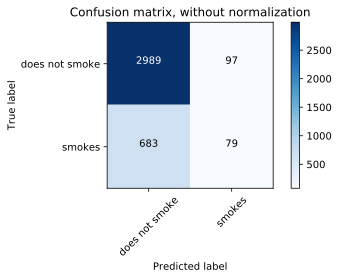

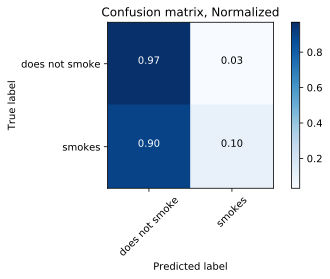

In [324]:
confusion_matrices(best_logreg)

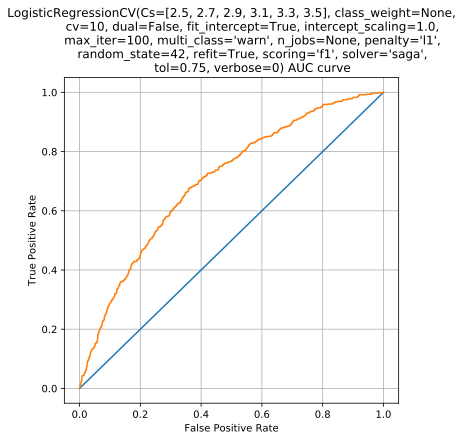

In [326]:
plot_auc_curve(best_logreg)

# Support Vector Machine (SVM)

In [401]:
svm = SVC(probability = True)

Cs=[.75 .5, 1, 1.25, 1.5]
kernels = ['linear','rbf','sigmoid']
gammas = ['scale', 'auto']
tols = [.0001, .001, .01,]

param_grid = dict(C=Cs, tol=tols, gamma=gammas, kernel=kernels)

grid_svm = GridSearchCV(svm, param_grid, cv=10, scoring='f1', n_jobs=-1)

grid_svm.fit(X_train, y_train)

print(grid_svm.best_score_)
print(grid_svm.best_params_)
print(grid_svm.best_estimator_)

0.33066757419593024
{'C': 0.75, 'gamma': 'scale', 'kernel': 'linear', 'tol': 10}
SVC(C=0.75, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True, tol=10,
  verbose=False)


In [406]:
y_pred_best_svm = grid_svm.predict(X_test)

print(metrics.classification_report(y_test, y_pred_best_svm))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      3086
           1       0.00      0.00      0.00       762

   micro avg       0.80      0.80      0.80      3848
   macro avg       0.40      0.50      0.45      3848
weighted avg       0.64      0.80      0.71      3848



/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [407]:
metrics.accuracy_score(y_test, y_pred_best_svm)

0.8019750519750519

Confusion matrix, without normalization
[[3086    0]
 [ 762    0]]
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


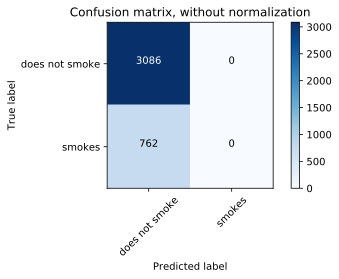

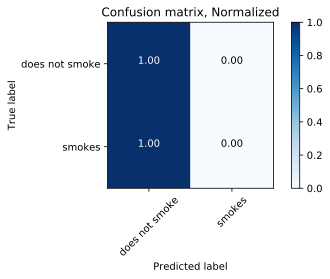

In [408]:
confusion_matrices(grid_svm)

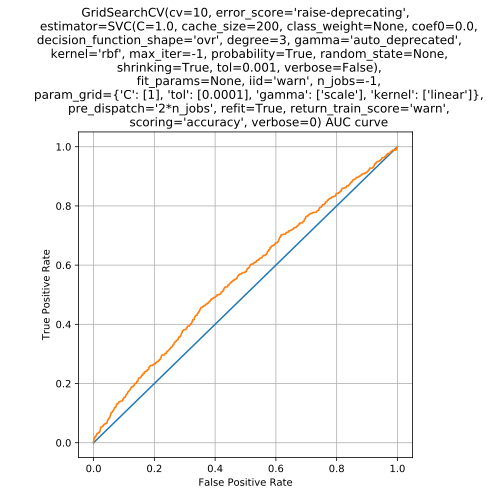

In [399]:
plot_auc_curve(grid_svm)

# Decision Trees

In [403]:
dtree = DecisionTreeClassifier(random_state=42)

dtree.fit(X_train[:3000], y_train[:3000])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [405]:
y_pred_dtree = dtree.predict(X_test[:3000])

In [409]:
metrics.f1_score(y_test[:3000], y_pred_dtree)

0.26086956521739135

Confusion matrix, without normalization
[[2475  611]
 [ 548  214]]
Normalized confusion matrix
[[0.8  0.2 ]
 [0.72 0.28]]


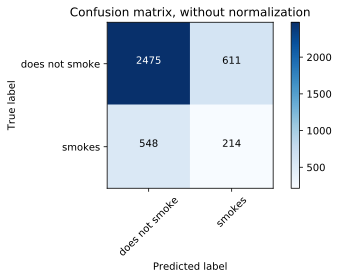

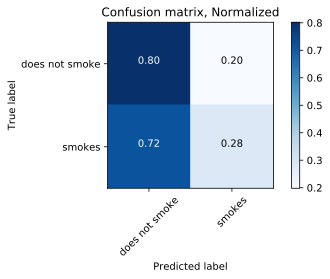

In [410]:
confusion_matrices(dtree)

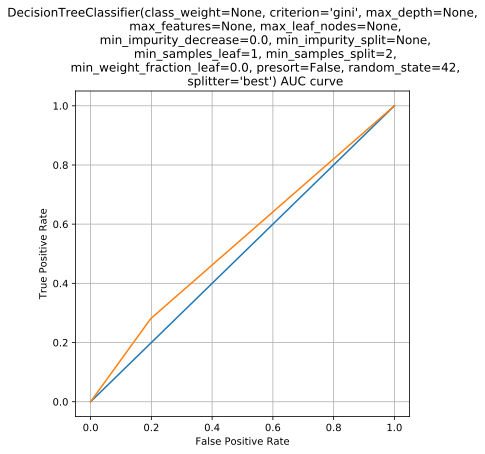

In [412]:
plot_auc_curve(dtree)

# Random Forrest

In [414]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=100)

rf.fit(X_train[:3000], y_train[:3000])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [415]:
y_pred_rf = rf.predict(X_test[:3000])

0.08902077151335311
Confusion matrix, without normalization
[[3014   72]
 [ 719   43]]
Normalized confusion matrix
[[0.98 0.02]
 [0.94 0.06]]


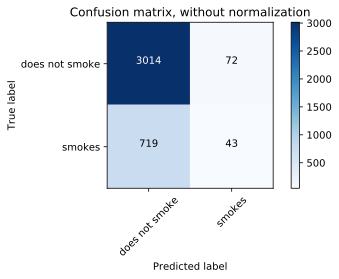

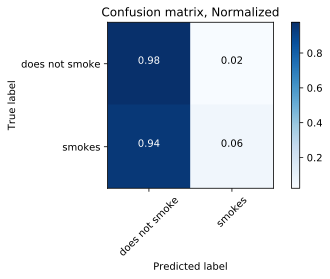

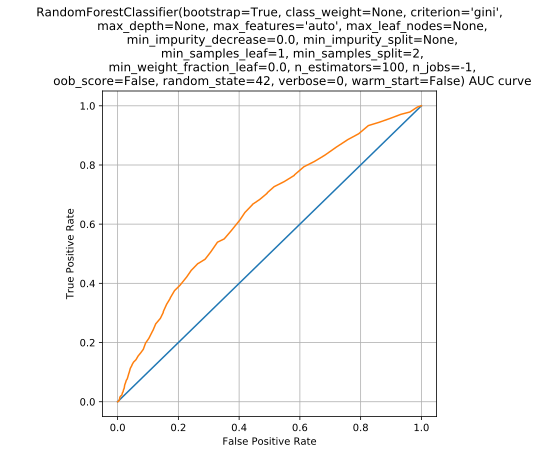

In [417]:
print(metrics.f1_score(y_test[:3000], y_pred_rf))

confusion_matrices(rf)
plot_auc_curve(rf)

# Gradient Boosting

In [478]:
gb = GradientBoostingClassifier(random_state=42)

losses = ['deviance', 'exponential']
lrs = [.001, .01, .1, .5, 1]
n_ests = [100, 200, 500, 1000, 2000, 5000]
subsamples=[0.1, 0.3, 0.5, 0.7, 0.9, 1]
# criterions=[
# mins=[
# minl=[
maxd = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
tols = [.00001, .0001, .001, .01, .1, 1, 10]
    
    

param_grid = dict(loss=losses, learning_rate=lrs, n_estimators=n_ests, subsample=subsamples,
                 max_depth=maxd, tol=tols)

grid_gb = RandomizedSearchCV(gb, param_grid, scoring='f1', cv=10, n_jobs=6, n_iter=15)

grid_gb.fit(X_train[:2000], y_train[:2000])

print(grid_gb.best_score_)
print(grid_gb.best_params_)
print(grid_gb.best_estimator_)

/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.2685525758528585
{'tol': 0.001, 'subsample': 0.7, 'n_estimators': 2000, 'max_depth': 5, 'loss': 'deviance', 'learning_rate': 1}
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=2000,
              n_iter_no_change=None, presort='auto', random_state=42,
              subsample=0.7, tol=0.001, validation_fraction=0.1, verbose=0,
              warm_start=False)


In [479]:
gb = GradientBoostingClassifier(random_state=42)

losses = ['deviance', 'exponential']
lrs = [0.1, .5, 1, 1.5]
n_ests = [1000, 2000, 3000]
subsamples=[0.5, 0.7, 0.9,]
# criterions=[
# mins=[
# minl=[
maxd = [5, 7]
tols = [.0001]
    
    

param_grid = dict(loss=losses, learning_rate=lrs, n_estimators=n_ests, subsample=subsamples,
                 max_depth=maxd, tol=tols)

grid_gb = RandomizedSearchCV(gb, param_grid, scoring='f1', cv=10, n_jobs=6, n_iter=15)

grid_gb.fit(X_train[:2000], y_train[:2000])

print(grid_gb.best_score_)
print(grid_gb.best_params_)
print(grid_gb.best_estimator_)

0.30099085016988353
{'tol': 0.0001, 'subsample': 0.5, 'n_estimators': 3000, 'max_depth': 5, 'loss': 'deviance', 'learning_rate': 1}
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=3000,
              n_iter_no_change=None, presort='auto', random_state=42,
              subsample=0.5, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)


In [473]:
gb = GradientBoostingClassifier(random_state=42)

losses = ['deviance', 'exponential']
lrs = [0.1, .5, 1, 1.5]
n_ests = [1000, 2000, 3000]
subsamples=[0.5, 0.7, 0.9,]
# criterions=[
# mins=[
# minl=[
maxd = [5, 7,]
tols = [.0001]
    
    

param_grid = dict(loss=losses, learning_rate=lrs, n_estimators=n_ests, subsample=subsamples,
                 max_depth=maxd, tol=tols)

grid_gb = GridSearchCV(gb, param_grid, scoring='f1', cv=10, n_jobs=6)

grid_gb.fit(X_train, y_train)

print(grid_gb.best_score_)
print(grid_gb.best_params_)
print(grid_gb.best_estimator_)

KeyboardInterrupt: 

In [424]:
y_pred_gb = grid_gb.predict(X_test)

metrics.f1_score(y_test, y_pred_gb)

In [435]:
print(metrics.classification_report(y_test, y_pred_gb))

              precision    recall  f1-score   support

           0       0.81      0.98      0.89      3086
           1       0.46      0.07      0.11       762

   micro avg       0.80      0.80      0.80      3848
   macro avg       0.64      0.52      0.50      3848
weighted avg       0.74      0.80      0.73      3848



Confusion matrix, without normalization
[[3028   58]
 [ 712   50]]
Normalized confusion matrix
[[0.98 0.02]
 [0.93 0.07]]


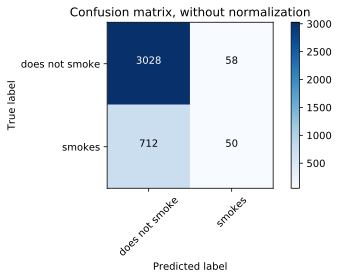

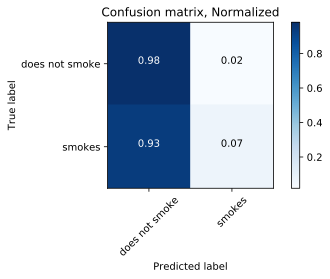

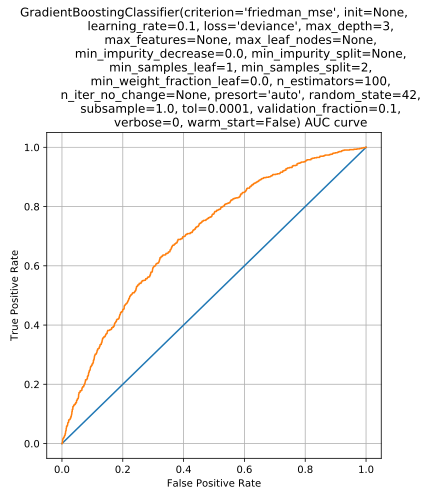

In [425]:
confusion_matrices(grid_gb)
plot_auc_curve(grid_gb)

# Naive Bayes

In [426]:
nb = GaussianNB()

nb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [427]:
y_pred_nb = nb.predict(X_test)

In [428]:
metrics.f1_score(y_test, y_pred_nb)

0.3821285869960043

In [433]:
print(metrics.classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.87      0.53      0.66      3086
           1       0.26      0.69      0.38       762

   micro avg       0.56      0.56      0.56      3848
   macro avg       0.57      0.61      0.52      3848
weighted avg       0.75      0.56      0.60      3848



Confusion matrix, without normalization
[[1621 1465]
 [ 236  526]]
Normalized confusion matrix
[[0.53 0.47]
 [0.31 0.69]]


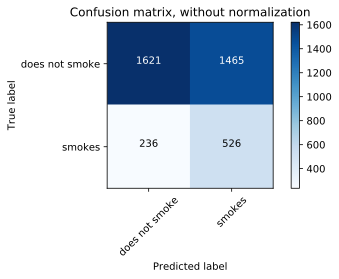

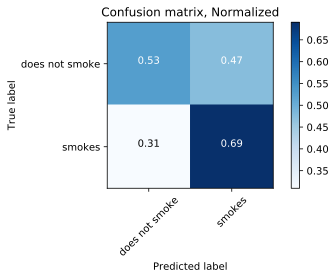

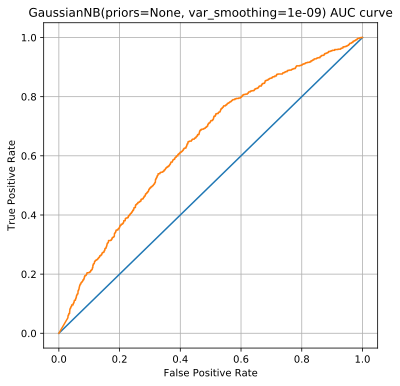

In [429]:
confusion_matrices(nb)
plot_auc_curve(nb)

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10, 4))
fig.set_figwidth(10)
fig.set_figheight(6)

fig.suptitle('Main Title',fontsize = 16)

ax[0].plot(new_x,new_y)
ax[0].set_title('Line Chart')

ax[1].bar(new_x,new_y)
ax[1].set_title('Bar Chart');